In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense,LSTM,GRU


import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
data = pd.read_csv('./dataset/CH22_Demand_XY_Train.csv', parse_dates = ['DateTime'], index_col=0)
data.index.name='DateTime'

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41932 entries, 2022-01-01 00:00:00 to 2022-10-19 04:30:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      41932 non-null  float64
 1   X2      41932 non-null  float64
 2   X3      41932 non-null  float64
 3   X4      41932 non-null  float64
 4   Y       41932 non-null  float64
dtypes: float64(5)
memory usage: 1.9 MB


In [4]:
data.head()

X1     X2      X3      X4             Y
DateTime                                                          
2022-01-01 00:00:00  2.186333  13.76  0.0663  0.1547  521163.83540
2022-01-01 00:10:00  2.138000  13.90  0.0910  0.1105  449066.62018
2022-01-01 00:20:00  2.104333  13.90  0.0806  0.1300  437394.72159
2022-01-01 00:30:00  2.040333  14.00  0.1183  0.1248  422107.63292
2022-01-01 00:40:00  1.973667  14.14  0.0624  0.1105  406923.83540

In [5]:
data.columns

Index(['X1', 'X2', 'X3', 'X4', 'Y'], dtype='object')

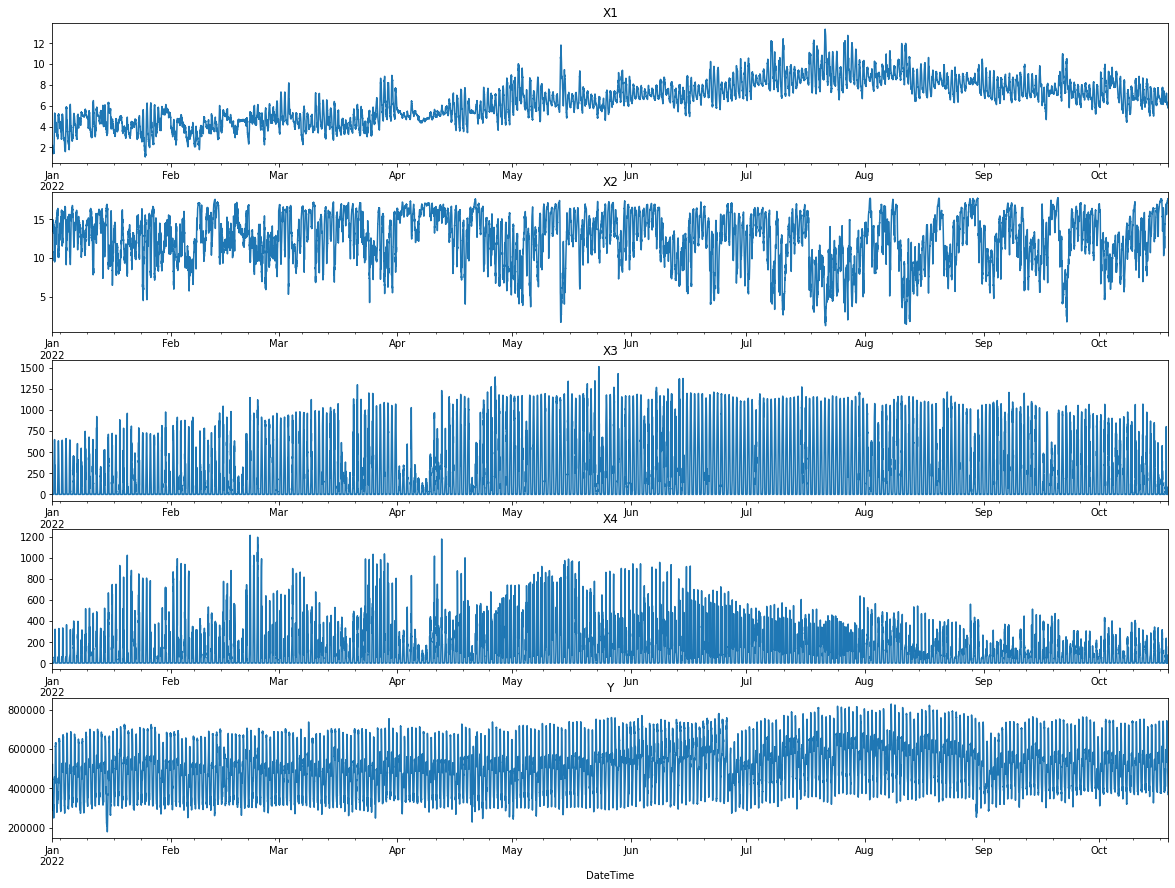

In [6]:
fig,ax = plt.subplots(5,1,figsize=(20,15))
for i,column in enumerate([col for col in data.columns if col != 'wnd_dir']):
    data[column].plot(ax=ax[i])
    ax[i].set_title(column)

In [7]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [8]:
labelEncoder = LabelEncoder()
data.iloc[:,4] = labelEncoder.fit_transform(data.iloc[:,4])
values = data.values
print(values.shape)
values = values.astype('float32')

(41932, 5)


In [9]:
values

array([[2.1863334e+00, 1.3760000e+01, 6.6299997e-02, 1.5470000e-01,
        1.1918000e+04],
       [2.1380000e+00, 1.3900000e+01, 9.0999998e-02, 1.1050000e-01,
        7.7830000e+03],
       [2.1043334e+00, 1.3900000e+01, 8.0600001e-02, 1.3000000e-01,
        7.1740000e+03],
       ...,
       [5.8466668e+00, 1.7680000e+01, 1.0010000e-01, 1.9760001e-01,
        3.8880000e+03],
       [5.8566666e+00, 1.7660000e+01, 1.1830000e-01, 1.3910000e-01,
        3.8740000e+03],
       [5.8766665e+00, 1.7680000e+01, 7.6700002e-02, 1.6900000e-01,
        4.0340000e+03]], dtype=float32)

In [10]:
series_to_supervised(values,1,1)

var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var1(t)  \
1       2.186333  13.760000     0.0663     0.1547    11918.0  2.138000   
2       2.138000  13.900000     0.0910     0.1105     7783.0  2.104333   
3       2.104333  13.900000     0.0806     0.1300     7174.0  2.040333   
4       2.040333  14.000000     0.1183     0.1248     6360.0  1.973667   
5       1.973667  14.140000     0.0624     0.1105     5613.0  1.951000   
...          ...        ...        ...        ...        ...       ...   
41927   5.863333  17.639999     0.0897     0.2067     3617.0  5.856667   
41928   5.856667  17.660000     0.1092     0.1391     3470.0  5.860000   
41929   5.860000  17.660000     0.1183     0.1495     3627.0  5.846667   
41930   5.846667  17.680000     0.1001     0.1976     3888.0  5.856667   
41931   5.856667  17.660000     0.1183     0.1391     3874.0  5.876667   

       var2(t)  var3(t)  var4(t)  var5(t)  
1        13.90   0.0910   0.1105   7783.0  
2        13.90   0.0806   0.1300   7174.0  
3        14.00   0.1183   0.1248   6360.0  
4        14.14   0.0624   0.1105   5613.0  
5        14.38   0.0767   0.1404   4981.0  
...        ...      ...      ...      ...  
41927    17.66   0.1092   0.1391   3470.0  
41928    17.66   0.1183   0.1495   3627.0  
41929    17.68   0.1001   0.1976   3888.0  
41930    17.66   0.1183   0.1391   3874.0  
41931    17.68   0.0767   0.1690   4034.0  

[41931 rows x 10 columns]

In [11]:
reframed = series_to_supervised(values,1,1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[5 , 6 , 7 , 8 ,9 ]], axis=1, inplace=True)
reframed.head()

var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)
1   2.186333      13.76     0.0663     0.1547    11918.0
2   2.138000      13.90     0.0910     0.1105     7783.0
3   2.104333      13.90     0.0806     0.1300     7174.0
4   2.040333      14.00     0.1183     0.1248     6360.0
5   1.973667      14.14     0.0624     0.1105     5613.0

In [12]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled,1,1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[5 , 6 , 7 , 8 ,9 ]], axis=1, inplace=True)
reframed.head()

var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)
1   0.090091   0.757458   0.000040   0.000107   0.532339
2   0.086146   0.765947   0.000057   0.000071   0.347642
3   0.083399   0.765947   0.000050   0.000087   0.320440
4   0.078176   0.772011   0.000075   0.000082   0.284081
5   0.072736   0.780500   0.000038   0.000071   0.250715

In [13]:
values = reframed.values
n_train = 33545
train = values[:n_train]
test = values[n_train:]
trainX,trainY = train[:,:-1],train[:,-1]
testX,testY = test[:,:-1],test[:,-1]

In [14]:
print(trainX.shape,trainY.shape,testX.shape,testY.shape)

(33545, 4) (33545,) (8386, 4) (8386,)


In [15]:
trainX = trainX.reshape(trainX.shape[0],1,trainX.shape[1])
testX = testX.reshape(testX.shape[0],1,testX.shape[1])

In [17]:
print(trainX.shape)
print(testX.shape)

(33545, 1, 4)
(8386, 1, 4)


In [18]:
stop_noimprovement = EarlyStopping(patience=10)
model = Sequential()
model.add(LSTM(50,input_shape=(trainX.shape[1],trainX.shape[2]),dropout=0.2))
model.add(Dense(1))
model.compile(loss="mae",optimizer="adam")



In [19]:
#Early Stop implemented 
history= model.fit(trainX,trainY,validation_data=(testX,testY),epochs=100,verbose=2,callbacks=[stop_noimprovement],shuffle=False)

#No Early Stop
# history= model.fit(trainX,trainY,validation_data=(testX,testY),epochs=100,verbose=2,shuffle=False)

2022-01-30 03:26:19.155390: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/100
1049/1049 - 1s - loss: 0.2283 - val_loss: 0.2141 - 1s/epoch - 1ms/step
Epoch 2/100
1049/1049 - 1s - loss: 0.2204 - val_loss: 0.2191 - 611ms/epoch - 582us/step
Epoch 3/100
1049/1049 - 1s - loss: 0.2189 - val_loss: 0.2203 - 612ms/epoch - 584us/step
Epoch 4/100
1049/1049 - 1s - loss: 0.2169 - val_loss: 0.2214 - 610ms/epoch - 582us/step
Epoch 5/100
1049/1049 - 1s - loss: 0.2160 - val_loss: 0.2163 - 587ms/epoch - 560us/step
Epoch 6/100
1049/1049 - 1s - loss: 0.2156 - val_loss: 0.2185 - 610ms/epoch - 581us/step
Epoch 7/100
1049/1049 - 1s - loss: 0.2151 - val_loss: 0.2199 - 612ms/epoch - 583us/step
Epoch 8/100
1049/1049 - 1s - loss: 0.2134 - val_loss: 0.2179 - 610ms/epoch - 582us/step
Epoch 9/100
1049/1049 - 1s - loss: 0.2133 - val_loss: 0.2143 - 608ms/epoch - 580us/step
Epoch 10/100
1049/1049 - 1s - loss: 0.2130 - val_loss: 0.2134 - 609ms/epoch - 581us/step
Epoch 11/100
1049/1049 - 1s - loss: 0.2125 - val_loss: 0.2118 - 609ms/epoch - 581us/step
Epoch 12/100
1049/1049 - 1s - loss:

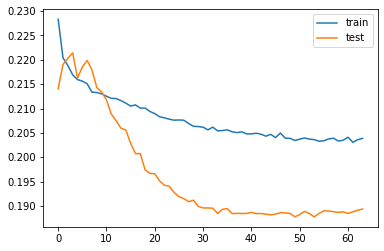

In [20]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.show()

In [21]:
predicted = model.predict(testX)

In [22]:
testXRe = testX.reshape(testX.shape[0],testX.shape[2])

In [23]:
predicted = np.concatenate((predicted,testXRe[:,1:]),axis=1)

In [24]:
predicted.shape

(8386, 4)

In [30]:
predicted 

array([[5.1134801e-01, 5.8149403e-01, 7.2227245e-05, 8.2266619e-05],
       [5.0615263e-01, 5.8877027e-01, 8.4265113e-05, 6.7309054e-05],
       [5.0744414e-01, 5.8707249e-01, 7.2227245e-05, 7.9061429e-05],
       ...,
       [2.8617978e-01, 9.9393648e-01, 7.4806791e-05, 1.0256618e-04],
       [2.8505695e-01, 9.9514920e-01, 6.2768915e-05, 1.4209689e-04],
       [2.8600723e-01, 9.9393648e-01, 7.4806791e-05, 9.4018993e-05]],
      dtype=float32)

In [33]:
testY 


array([[8.4554231e-01, 5.8149403e-01, 7.2227245e-05, 8.2266619e-05],
       [8.1396288e-01, 5.8877027e-01, 8.4265113e-05, 6.7309054e-05],
       [7.9484546e-01, 5.8707249e-01, 7.2227245e-05, 7.9061429e-05],
       ...,
       [1.6200644e-01, 9.9393648e-01, 7.4806791e-05, 1.0256618e-04],
       [1.7366447e-01, 9.9514920e-01, 6.2768915e-05, 1.4209689e-04],
       [1.7303914e-01, 9.9393648e-01, 7.4806791e-05, 9.4018993e-05]],
      dtype=float32)

In [34]:
testY.shape

(8386, 4)

In [35]:
testY = np.concatenate((testY,testXRe[:,1:]),axis=1)

In [36]:
testY 

array([[8.4554231e-01, 5.8149403e-01, 7.2227245e-05, ..., 5.8149403e-01,
        7.2227245e-05, 8.2266619e-05],
       [8.1396288e-01, 5.8877027e-01, 8.4265113e-05, ..., 5.8877027e-01,
        8.4265113e-05, 6.7309054e-05],
       [7.9484546e-01, 5.8707249e-01, 7.2227245e-05, ..., 5.8707249e-01,
        7.2227245e-05, 7.9061429e-05],
       ...,
       [1.6200644e-01, 9.9393648e-01, 7.4806791e-05, ..., 9.9393648e-01,
        7.4806791e-05, 1.0256618e-04],
       [1.7366447e-01, 9.9514920e-01, 6.2768915e-05, ..., 9.9514920e-01,
        6.2768915e-05, 1.4209689e-04],
       [1.7303914e-01, 9.9393648e-01, 7.4806791e-05, ..., 9.9393648e-01,
        7.4806791e-05, 9.4018993e-05]], dtype=float32)

In [37]:
pd.DataFrame(testY)

0         1         2         3         4         5         6
0     0.845542  0.581494  0.000072  0.000082  0.581494  0.000072  0.000082
1     0.813963  0.588770  0.000084  0.000067  0.588770  0.000084  0.000067
2     0.794845  0.587072  0.000072  0.000079  0.587072  0.000072  0.000079
3     0.761971  0.574218  0.000072  0.000067  0.574218  0.000072  0.000067
4     0.732535  0.572520  0.000088  0.000027  0.572520  0.000088  0.000027
...        ...       ...       ...       ...       ...       ...       ...
8381  0.161560  0.992724  0.000056  0.000150  0.992724  0.000056  0.000150
8382  0.154994  0.993936  0.000069  0.000094  0.993936  0.000069  0.000094
8383  0.162006  0.993936  0.000075  0.000103  0.993936  0.000075  0.000103
8384  0.173664  0.995149  0.000063  0.000142  0.995149  0.000063  0.000142
8385  0.173039  0.993936  0.000075  0.000094  0.993936  0.000075  0.000094

[8386 rows x 7 columns]

In [38]:
np.sqrt(mean_squared_error(testY[:,0],predicted[:,0]))

0.23656234

In [39]:
result = pd.concat([pd.Series(predicted[:,0]),pd.Series(testY[:,0])],axis=1)
result.columns = ['thetahat','theta']
result['diff'] = result['thetahat'] - result['theta']

In [40]:
result

thetahat     theta      diff
0     0.511348  0.845542 -0.334194
1     0.506153  0.813963 -0.307810
2     0.507444  0.794845 -0.287401
3     0.512581  0.761971 -0.249390
4     0.511530  0.732535 -0.221006
...        ...       ...       ...
8381  0.286905  0.161560  0.125346
8382  0.286002  0.154994  0.131008
8383  0.286180  0.162006  0.124173
8384  0.285057  0.173664  0.111392
8385  0.286007  0.173039  0.112968

[8386 rows x 3 columns]

In [41]:
from keras.models import load_model

# model.save('my_model.h5')

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                11000     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 11,051
Trainable params: 11,051
Non-trainable params: 0
_________________________________________________________________
